<table>
<tr>
    <td width=25%>
        <img src=" 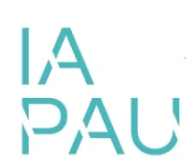" />
    </td>
    <td>
        <center>
            <h1>Meetup machine learning Pau</h1>
        </center>
    </td>
    <td width=15%>
        Paul Gay
    </td>
</tr>
</table>

<br/>
<div id="top"></div>
<center>
    <a style="font-size: 20pt; font-weight: bold">Tester les transformeurs sur une tâche de classification</a>
<br/>
    Meetup 12 mai 2021 <br>
</center>
<br/>

---
---
Ce notebook vous propose d'effectuer de la classification de texte. Nous allons implémenter un modèle simple constitué d'un encodeur contenant un bloc d'auto attention avec 2 têtes. 

Les données sont des séquences de 200 mots venant du jeu de donnée classique **imdb** et correspondant à des critiques de films.

Ce notebook s'inspire d'un tutoriel de [tensorflow](https://www.tensorflow.org/tutorials/text/transformer) qui propose d'écrire un modèle de traduction. Vous pouvez consulter cette ressource pour construire un encodeur/décodeur.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

Commençons par charger les données, (que nous connaissons bien maintenant)

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "séquences d'entraînement")
print(len(x_val), "séquences de validation")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
word2idx = tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json")
idx2word = dict([(k,w) for (w,k) in word2idx.items() ])

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/paul/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/paul/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

25000 séquences d'entraînement
25000 séquences de validation


In [3]:
idx2word = dict([(k,w) for (w,k) in word2idx.items() ])

Affichons le texte d'une critique.

In [4]:
print(' '.join([idx2word[i] for i in x_train[1]  if i in idx2word ]))

the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch stefan of solid it thought begins br senator machinations budget worthwhile though ok brokedown awaiting for ever better were and diverse for budget look kicked any to of making it out and follows for effects show to show cast this family us scenes more it severe making senator to and finds tv tend to of emerged these thing wants but and an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them


### Positional encoding

Nous construisons un encodage de la position de dimension $d=500$ en utilisant les formules : 
 $$ PE(pos, 2i) =  sin(pos/10000^{2i/d})$$
 $$ PE(pos, 2i+1) =  cos(pos/10000^{2i/d})$$

In [5]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  """
  position : valeur maximale de la position, c'est à dire la taille maximale de la séquence
  d_model : dimension de l'encodage d'entrée du transformeur.
  """
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


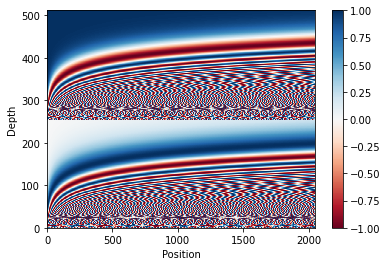

In [18]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
#plt.show()
plt.savefig('positional_embedding.png')

Sur cette figure, chaque colonne correspond à un encodage pour une position particulière. 

La première colonne est l'encodage du premier token, la seconde du deuxième, etc.

### Classe finale de l'encodage

Nous créons à présent une couche permettant de créer notre plongement lexical. Ce vecteur sera l'entrée de notre transformeur qui le raffinera en y intégrant le contexte. 

Une partie de ce vecteur correspond à un plongement de type word2vec, constitué d'une couche Embedding de Keras qui sera apprise par le réseau. Ce vecteur associe un vecteur à chaque token sans tenir compte du contexte. 

À cela s'ajoute un descripteur qui encode la position du mot dans la phrase en utilisant les fonctions décrites précédemment.

In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = positional_encoding(maxlen, embed_dim)
        self.embed_dim = embed_dim

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.token_emb(x)
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32)) # normalisation des embeddings en fonction de leur dimension
        x += self.pos_emb[:, :maxlen, :] # ajout du plongement encodant la position
        return x

Testons notre nouvelle couche sur un vecteur aléatoire: 

In [10]:
embed_dim = 512
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
out = embedding_layer(x_train[0])
print(out.shape)

(1, 200, 512)


Cette fonction calcule les scores d'attention

In [11]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calcul des poids d'attention
  q, k, v doivent avoir la même dimension
  k, v doivent avoir la même avant dernière dimension, i.e.: seq_len_k = seq_len_v.
  
  Args:
    q: requête de taille == (..., seq_len_q, depth)
    k: clé de taille == (..., seq_len_k, depth)
    v: valeur de taille == (..., seq_len_v, depth_v)
    mask: Tenseur de rééls pouvant être additionné aux valeurs de taille (..., seq_len_q, seq_len_k). La valeur par défaut est None.

  Returns:
    output, attention_weights
  """

  # multiplication entre la clé et la requête
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # normalisation par la taille de l'état interne du modèle
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # Ajout du masque
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # Softmax le long de la dernière dimension afin que la somme des poids égale 1. 
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  # Somme pondérée des valeurs par les poids d'attention
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Quelques tests additionels

In [12]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)


Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Couche d'auto attention pouvant comporter plusieurs têtes. 

Notez que dans ce cas, le vecteur latent du modèle est divisé en plusieurs parties chacune correspondant à une tête.

Une autre possibilité serait d'ajouter un nouveau ensemble (clé, valeur, requête) pour chacune des têtes.

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    # projection du plongement afin de construire les vecteurs de clés, valeurs, et requêtes
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Test de notre nouvelle couche

In [14]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape


(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Bloc transformeur qui ajoute les couches connectées aux couches d'attention

In [15]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = keras.Sequential(
            [layers.Dense(dff, activation="relu"), layers.Dense(d_model),]
        )
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training):
    attn_output, attn_weights = self.mha(x, x, x, None)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    return out2, attn_weights


Test de notre couche de l'encodeur

In [16]:
# test d'une couche de l'encodeur
sample_encoder_layer = EncoderLayer(32, 2, 32*4)
sample_encoder_layer_output, attn_weights = sample_encoder_layer(
    tf.random.uniform((64, 43, 32)), False )
print('size of the decoder output', sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

size of the decoder output (64, 43, 32)


## Assemblage du modèle et entraînement

Modèle final de notre encodeur, où nous ajoutons un pooling pour revenir à une taille fixe et un softmax pour prédire le nombre de classes

In [19]:
embed_dim =  32 # Taille de l'encodage
num_heads = 2  # Nombre de têtes
ff_dim = embed_dim*4   # Taille de la couche connectée à l'intérieur du bloc transformeur

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = EncoderLayer(embed_dim, num_heads, ff_dim)
x, attn_output = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           640000    
_________________________________________________________________
encoder_layer_1 (EncoderLaye ((None, 200, 32), (None,  12704     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 20)                660       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0     

Entrainement du modèle

In [20]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 30s 38ms/step - loss: 0.4837 - accuracy: 0.7380 - val_loss: 0.2785 - val_accuracy: 0.8831
Epoch 2/2
782/782 [==============================] - 29s 37ms/step - loss: 0.1738 - accuracy: 0.9372 - val_loss: 0.3345 - val_accuracy: 0.8676


## Intérprétation du modèle 

À présent, affichons les poids d'attention et essayons de comprendre l'information qui est sélectionné par ce mécanisme. 

Nous n'afficherons qu'une partie des poids pour des raisons pratiques, afficher les matrices complètes de 200 par 200 serait illisible , 

In [22]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.layers[2].output)

In [49]:
def plot_attention_head(labels, attention):
  """ fonction affichant les poids d'attention
  chaque ligne correspond au poids d'attentions d'un mot de la séquence de sortie
  chaque colonne correspond à un mot en entrée
  """
  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(in_tokens)))

  ax.set_xticklabels(
      labels, rotation=90)

  ax.set_yticklabels(labels)


Nous affichons les poids d'attention pour les deux premières têtes de notre modèle. 
Nous séléctionnons un critique de l'ensemble de validation, calculons les poids, puis les affichons pour les 20 premiers mots. 

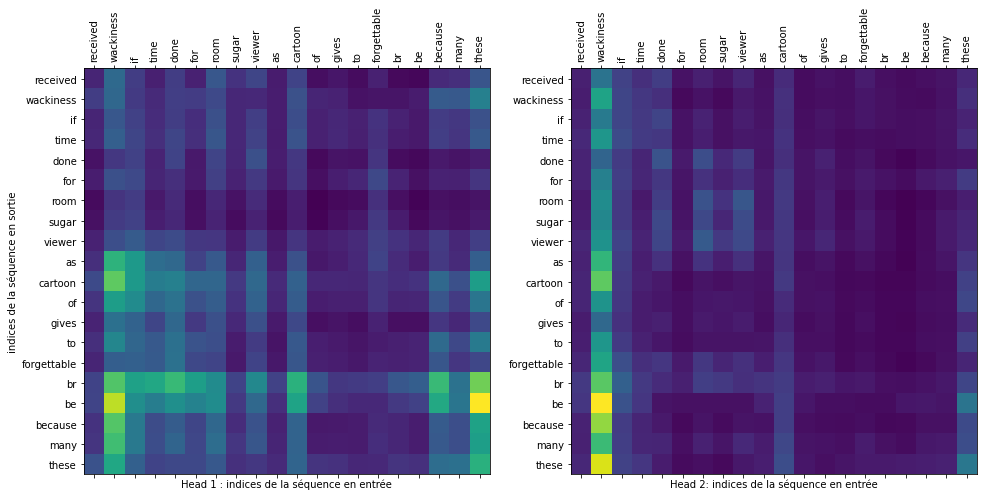

In [59]:
import matplotlib

first_tokens_to_display = 20
idx = 1 # indice de la critique dans l'ensemble de validation
output, attn_weights = intermediate_layer_model(x_val[idx].reshape(1,200))
attn_weights = tf.squeeze(attn_weights)
tokens = [idx2word[i] for i in x_val[idx]  if i in idx2word ]
in_tokens = tokens[:first_tokens_to_display]

fig = plt.figure(figsize=(16, 8))
# affichage de la première tête
ax = fig.add_subplot(1, 2, 1)
plot_attention_head(in_tokens, attn_weights[0,:first_tokens_to_display,:first_tokens_to_display])
ax.set_xlabel(f'Head {1} : indices de la séquence en entrée')
ax.set_ylabel(f'indices de la séquence en sortie')

# seconde tête
ax = fig.add_subplot(1, 2, 2)
plot_attention_head(in_tokens, attn_weights[1,:first_tokens_to_display,:first_tokens_to_display])
_ = ax.set_xlabel(f'Head {2}: indices de la séquence en entrée')